# 18 - Degree Distribution of Random Graphs

*September 20 2022*

We explore the expected degree distribution of random graphs. We investigate how the shape of the degree distribution depends on the number of nodes and links and we compare the expected distribution to degree distribution of empirical networks.

In [1]:
import pathpy as pp

import numpy as np
from scipy.stats import norm, poisson
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('default')
sns.set_style("whitegrid")

# Mean degree of random graphs

We first generate a number of random graphs based on the $G(n,p)$ model and calculate the mean degree of randomly chosen nodes. We then compare this to the expected mean degree of a random realization.

In fact, there are two different ways how we can approach this problem. The first approach calculates the mean of all degrees in each realization, and then averages those means across multiple realizations. In this case, we are actually calculating a double average (across all nodes in a realization and across all realizations). The question how to calculate the mean value of an ensemble is actually related to the concept of [ergodicity](https://en.wikipedia.org/wiki/Ergodicity) for dynamical systems in statistical physics. In a statistical ensemble of particle arrangements, we can either calculate thermodynamic quantities by averaging over all ensemble realizations (a so-called ensemble average) or we can average measurements obtained by measuring one (typical) position of the system over time.

The following code calculates a double average, i.e. we average the mean degrees of many realizations:

Mean degree =  2.4991
Expected degree =  2.5


/Users/ingo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

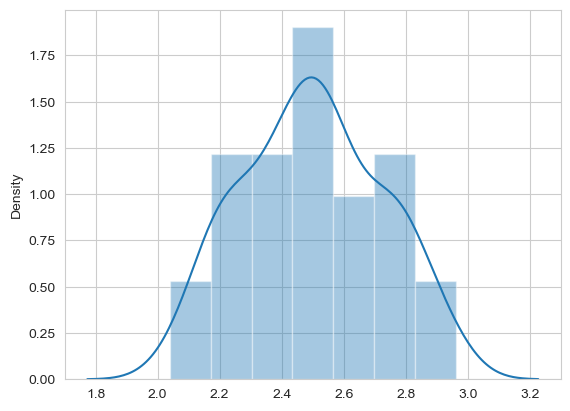

In [2]:
n = 100
p = 0.025
samples = 100

avg_deg = 0
degrees = []

for i in range(samples):
    network = pp.generators.random_graphs.ER_np(n=n, p=p, loops=True)    
    d = network.mean_degree()
    avg_deg += d
    degrees.append(d)
print('Mean degree = ', avg_deg/samples)
print('Expected degree = ', n*p)
sns.distplot(degrees)

Another approach would be to use each random realization to draw one node uniformly at random, calculate its degree and then average across multiple random nodes chosen in different realizations:

Mean degree =  2.54
Expected degree =  2.5


/Users/ingo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

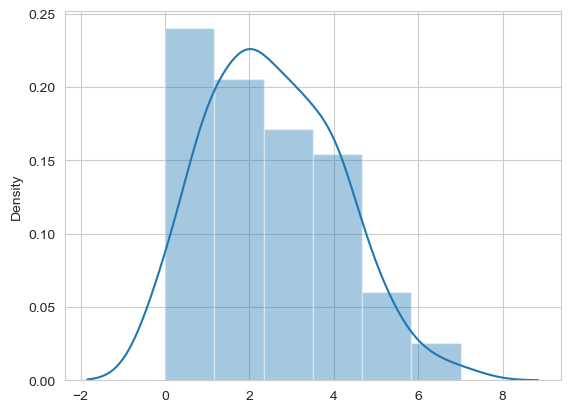

In [3]:
n = 100
p = 0.025
samples = 100

avg_deg = 0
degrees = []

for i in range(samples):
    network = pp.generators.random_graphs.ER_np(n=n, p=p, loops=True)
    d = network.degrees()[np.random.choice(list(network.nodes.uids))]
    avg_deg += d 
    degrees.append(d)
print('Mean degree = ', avg_deg/samples)
print('Expected degree = ', n*p)
sns.distplot(degrees)

These two different approaches lead to the same mean degree if we take a sufficiently large number of samples. However, the variance of the degrees in the first approach is smaller, since we have averaged over a larger number of nodes.

# Poisson vs. Normal approximation of degree distribution for random graphs

In the lecture, we have seen that the degree distribution of random graphs generated by the $G(n,p)$ model follows a Binomial distribution. Thanks to the De Moivre Laplace and the Poisson limit theorem we can approximate this distribution by a Normal or Poisson distribution if the networks are sufficiently large. Which approximation holds depends on the parameters $p$ and $n$. 

To investigate this further, we write a function that generates a random network with given mean degree (or link probability p), computes and plots the degree distribution as well as the corresponding Poissonian and Normal approximations:

In [6]:
def plot_dist(n, p=None, mean_degree=None, fit=None):

    if p is None:
        assert mean_degree is not None
        p = mean_degree/n
    else:
        assert mean_degree is None
        mean_degree = n*p
    
    std = np.sqrt(n*p * (1-p))

    fig, ax = plt.subplots(1, 1)

    g = pp.generators.random_graphs.ER_np(n=n, p=p, loops=True)
    d = pp.statistics.degree_distribution(g)
    x = np.arange(0, max(d.keys()))
    y = np.array([d[i] for i in x])
    ax.bar(x, y, label='degree dist (n = '+str(n)+')', alpha=0.5)

    if fit=='poisson':
        x_poiss = np.arange(poisson.ppf(0.001, mean_degree), poisson.ppf(0.999, mean_degree), step=1)
        ax.plot(x_poiss, poisson.pmf(x_poiss, mu=mean_degree), label='Poisson', color='darkred', lw=3, alpha=0.7)
        ax.set( xlim=(0, max(max(x), max(x_poiss)) ) )
    if fit=='normal':
        x_norm = np.arange(norm.ppf(0.001, mean_degree, std), norm.ppf(0.999, mean_degree, std), step=0.1)
        ax.plot(x_norm, norm.pdf(x_norm, mean_degree, std), label='Normal', lw=3, color='darkblue')
        ax.set( xlim=(0, max(max(x), max(x_norm)) ) )

    plt.legend()

If we fix the parameter $p$ to a constant value, as we increase the parameter $n$ the mean degree of relizations will increase and the degree distribution will converge to a Normal distribution. We see this in the following plots, which show that the empirical degree distribution increasingly look Normal as we increase $n$:

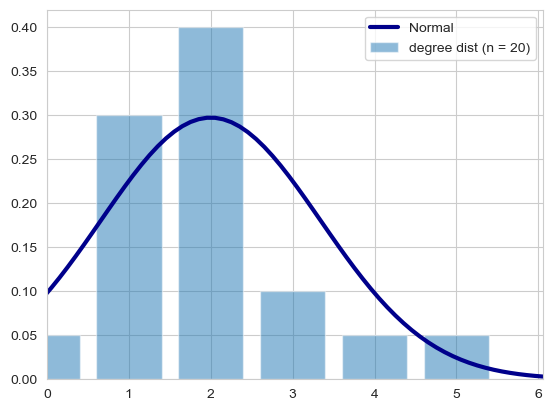

In [7]:
plot_dist(n=20, p=0.1, fit='normal')

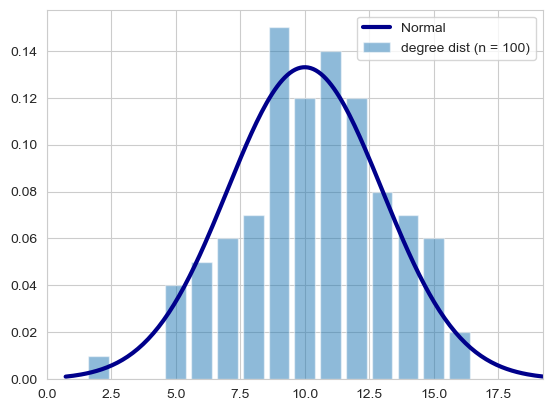

In [8]:
plot_dist(n=100, p=0.1, fit='normal')

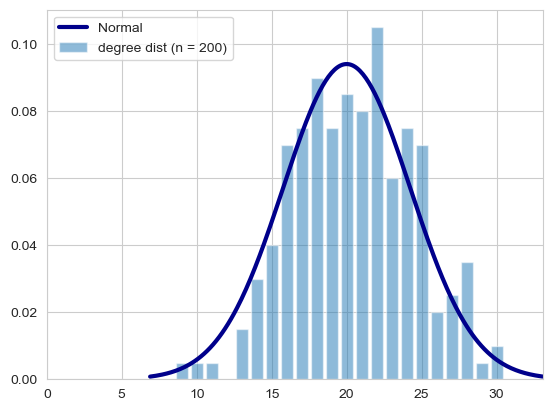

In [9]:
plot_dist(n=200, p=0.1, fit='normal')

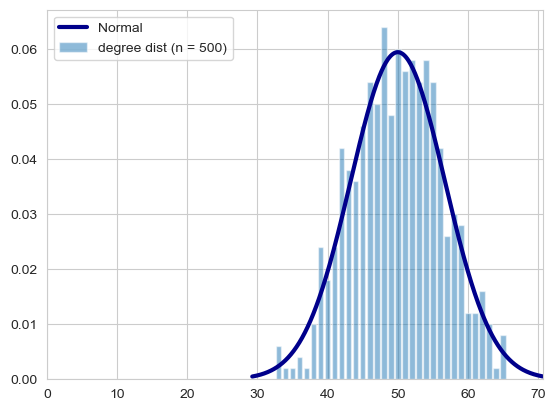

In [10]:
plot_dist(n=500, p=0.1, fit='normal')

If we fix the expected degree to a constant value, the parameter $p$ must converge to zero as $n$ goes to infinity. In this case, the Poisson limit theorem tells us that the Binomial degree distribution converges to a Poisson distribution with parameter $\lambda=np$. As we increase the size of the network, the similarity to the Poisson distribution gets stronger:

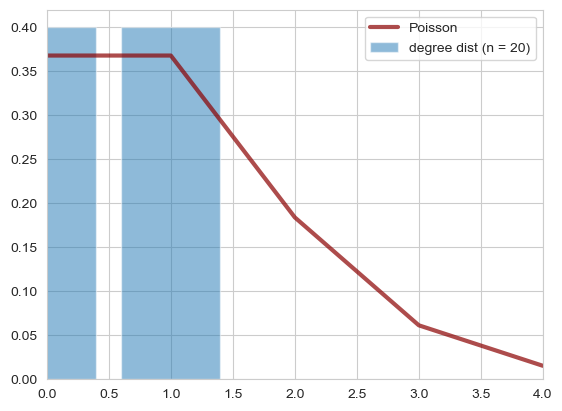

In [11]:
plot_dist(n=20, mean_degree=1, fit='poisson')

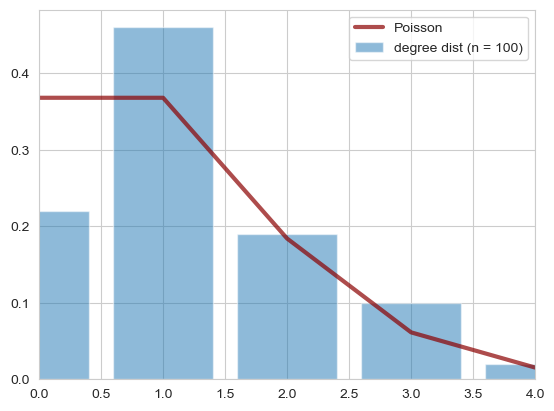

In [12]:
plot_dist(n=100, mean_degree=1, fit='poisson')

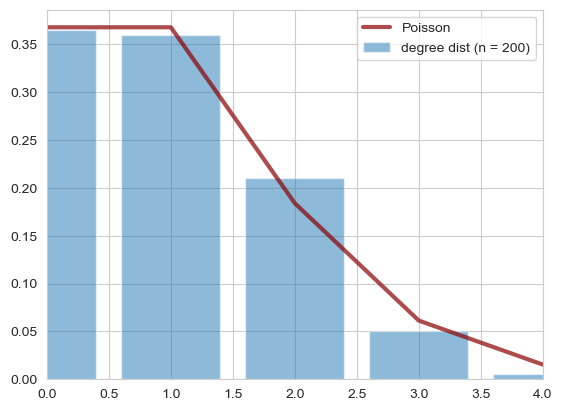

In [13]:
plot_dist(n=200, mean_degree=1, fit='poisson')

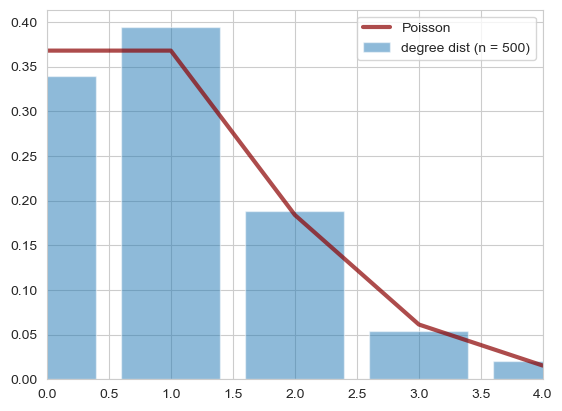

In [14]:
plot_dist(n=500, mean_degree=1, fit='poisson')

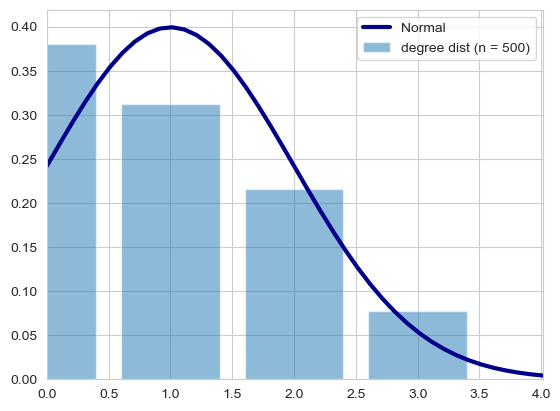

In [15]:
plot_dist(n=500, mean_degree=1, fit='normal')

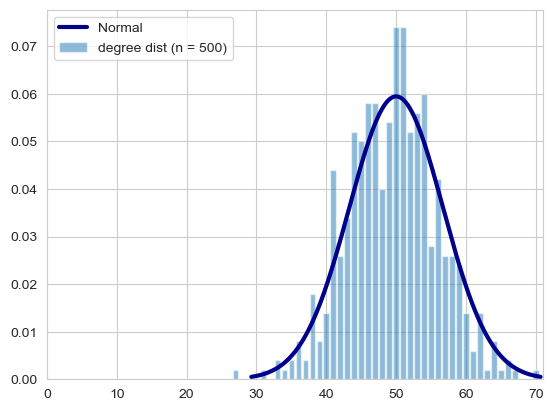

In [16]:
plot_dist(n=500, mean_degree=50, fit='normal')

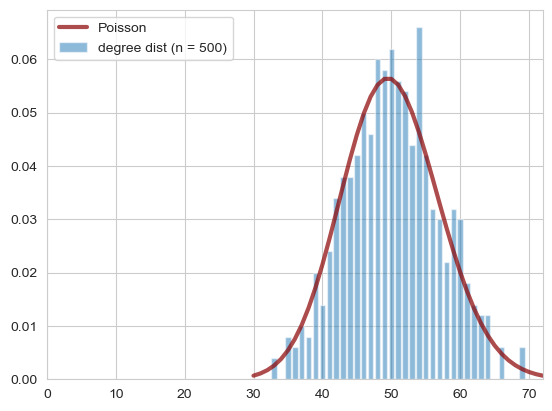

In [17]:
plot_dist(n=500, mean_degree=50, fit='poisson')

We can use the `fit` function in the class `scipy.stats.norm` to calculate the "most likely" parameters of a Normal distribution for the resulting degree distributions. We can then compare this to the limiting distributions given in the lecture:

In [18]:
def compare_fit(n, p):

    mu = n*p
    std = np.sqrt(mu * (1-p))

    print('limiting distribution: mu = {0}, sigma = {1}'.format(n*p, (n*p*(1-p))**0.5))

    g = pp.generators.random_graphs.ER_np(n=n, p=p, loops=True)
    fit = norm.fit(pp.statistics.degree_sequence(g))

    fitted_mu = fit[0]
    fitted_std = fit[1]
    print('fitted parameters: mu = {0}, sigma = {1}\n'.format(fitted_mu, fitted_std))

In [19]:
compare_fit(50, 0.1)

limiting distribution: mu = 5.0, sigma = 2.1213203435596424
fitted parameters: mu = 5.4, sigma = 1.865475810617763



In [20]:
compare_fit(1000, 0.05)

limiting distribution: mu = 50.0, sigma = 6.892024376045111
fitted parameters: mu = 49.968, sigma = 7.142196860910514



## Degree distribution of empirical vs. random networks

Let us now study the degree distribution of empirical networks, comparing them to the degree distribution of randomly generated microstates with the same macrostate. For this, we first load the three empirical networks from previous units:

In [21]:
n_gentoo = pp.io.sql.read_network('data/networks.db', sql='SELECT DISTINCT source, target FROM gentoo', directed=False, loops=False)
n_highschool = pp.io.sql.read_network('data/networks.db', sql='SELECT DISTINCT source, target FROM highschool', directed=False, loops=False)
n_physicians = pp.io.sql.read_network('data/networks.db', sql='SELECT DISTINCT source, target FROM physicians', directed=False, loops=False)
n_lotr = pp.io.sql.read_network('data/networks.db', sql='SELECT DISTINCT source, target FROM LOTR', directed=False, loops=False)

[11-23 16:31:40: WARNING] 154 edges existed already and were not be considered. To capture those edges, consider creating a multiedge and/or directed network.
[11-23 16:31:40: WARNING] 175 edges existed already and were not be considered. To capture those edges, consider creating a multiedge and/or directed network.
[11-23 16:31:40: WARNING] 67 edges existed already and were not be considered. To capture those edges, consider creating a multiedge and/or directed network.


In [22]:
def plot_fits(network, fit=None):

    d = pp.statistics.degree_distribution(network)

    mu = np.mean(pp.statistics.degree_sequence(network))
    print('Mean degree =', mu)
    std = np.std(pp.statistics.degree_sequence(network))

    fig, ax = plt.subplots(1, 1)

    x = np.arange(0, max(d.keys()))
    y = np.array([d[i] for i in x])
    ax.bar(x, y, label='degree dist (n = '+str(network.number_of_nodes())+')', alpha=0.5)

    if fit=='poisson':
        x_poiss = np.arange(poisson.ppf(0.001, mu), poisson.ppf(0.999, mu), step=1)
        ax.plot(x_poiss, poisson.pmf(x_poiss, mu=mu), label='Poisson', color='darkred', lw=3, alpha=0.7)
        ax.set( xlim=(0, max(max(x), max(x_poiss)) ) )
    if fit=='normal':
        x_norm = np.arange(norm.ppf(0.001, mu, std), norm.ppf(0.999, mu, std), step=0.1)
        ax.plot(x_norm, norm.pdf(x_norm, mu, std), label='Normal', lw=3, color='darkblue', alpha=0.7)
        ax.set( xlim=(0, max(max(x), max(x_norm)) ) )
    plt.legend()

Mean degree = 9.122302158273381


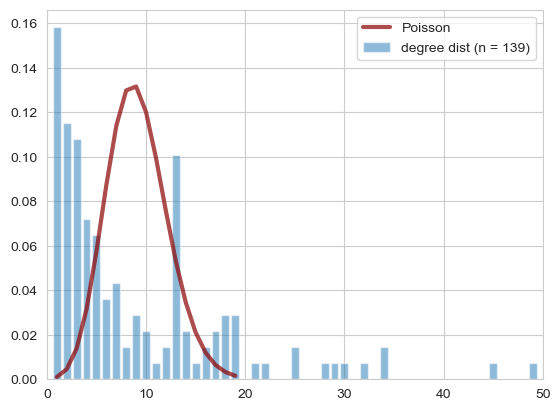

In [23]:
plot_fits(n_lotr, fit='poisson')

Mean degree = 9.122302158273381


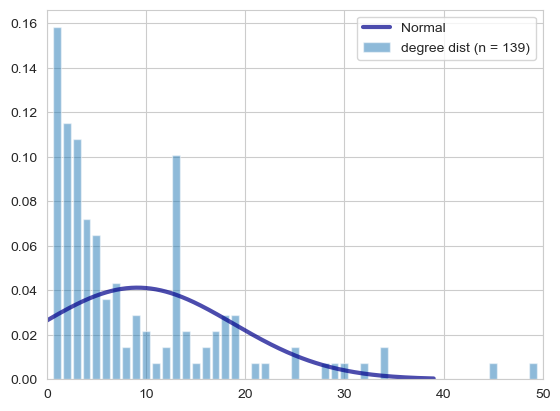

In [24]:
plot_fits(n_lotr, fit='normal')

Mean degree = 5.8


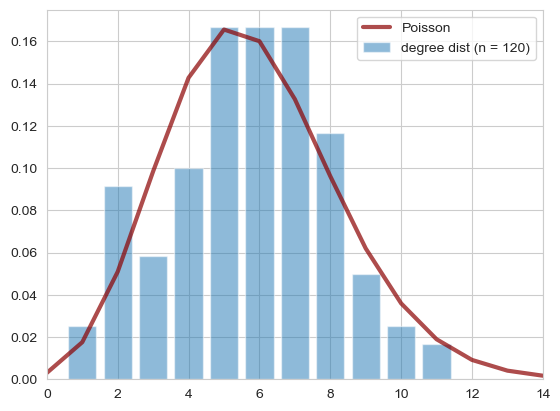

In [25]:
plot_fits(n_highschool, fit='poisson')

Mean degree = 5.8


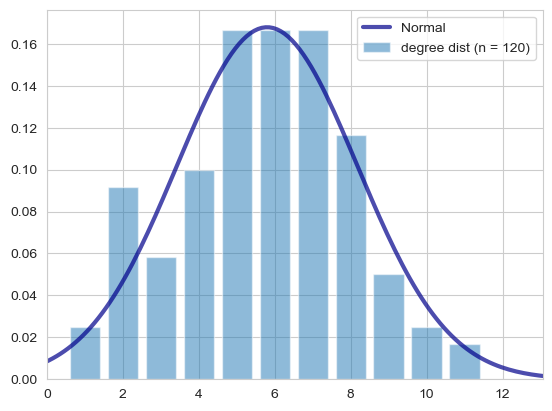

In [26]:
plot_fits(n_highschool, fit='normal')

Mean degree = 7.659751037344399


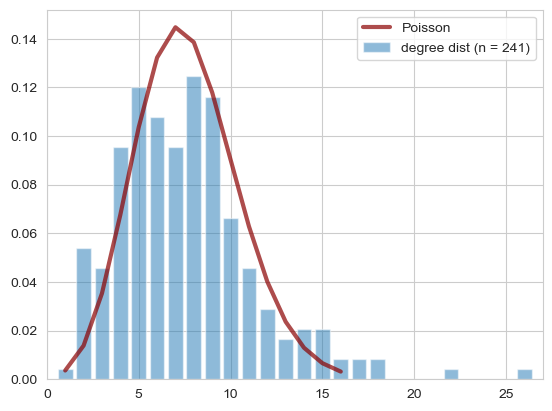

In [27]:
plot_fits(n_physicians, fit='poisson')

Mean degree = 7.659751037344399


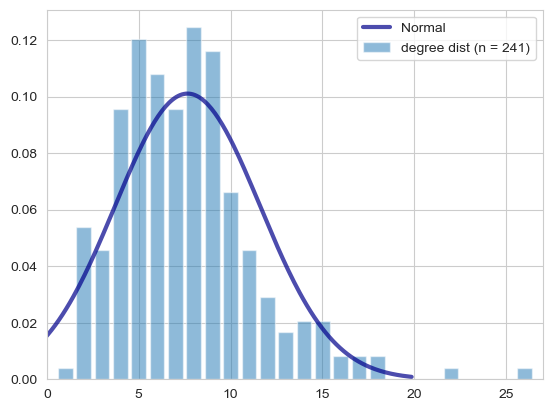

In [28]:
plot_fits(n_physicians, fit='normal')